In [1]:
import numpy as np
import pandas as pd
import torch
from torch.nn import *
from torch import arange as torch_arange
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from random import shuffle
from torch.utils.data import DataLoader, TensorDataset
import cv2

In [2]:
# Read the data
data_folder = os.path.join("data","landscape Images")
gray_folder = os.path.join(data_folder,"gray")
color_folder = os.path.join(data_folder,"color")
data=[]
for file in tqdm(set(os.listdir(gray_folder)).intersection(set(os.listdir(color_folder))),"Reading data images"):
    gray_image = plt.imread(os.path.join(gray_folder,file))
    color_image = cv2.cvtColor(cv2.imread(os.path.join(color_folder,file)),cv2.COLOR_BGR2RGB)
    if gray_image.shape==color_image.shape[:2] and gray_image.shape==(150,150):
        data.append([file,gray_image,color_image])
print(f"The size of the data is {len(data)}")

Reading data images: 100%|██████████| 7129/7129 [00:24<00:00, 296.54it/s]

The size of the data is 7106


In [50]:
batch_size = 32

test_size = 0.1
train_data= data[:int(len(data)*(1-test_size))]
test_data = data[int(len(data)*(1-test_size)):]
print(f"Size of train data: {len(train_data)}")
print(f"Size of test data: {len(test_data)}")
inputs = torch.tensor(np.array([d[1] for d in train_data]))
outputs = torch.tensor(np.array([d[2] for d in train_data]))
train_dataset = TensorDataset(inputs,outputs)
train_loader =  DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

inputs = torch.tensor(np.array([d[1] for d in test_data]))
outputs = torch.tensor(np.array([d[2] for d in test_data]))
test_dataset = TensorDataset(inputs,outputs)
test_loader =  DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

Size of train data: 6395
Size of test data: 711


In [51]:
class ImageColorizerCNNAutoEncoder(Module):
    def __init__(self):
        super(ImageColorizerCNNAutoEncoder,self).__init__()
        
        self.encoder = Sequential(
            Conv2d(in_channels=1,out_channels=64,kernel_size=(3,3),padding="same"),
            LeakyReLU(),
            MaxPool2d(kernel_size=(2,2),stride = 2),
            Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),padding="same"),
            LeakyReLU(),
            MaxPool2d(kernel_size=(2,2),stride = 2),
            Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),padding="same"),
            LeakyReLU(),
            MaxPool2d(kernel_size=(2,2),stride = 2),
            Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),padding="same"),
            LeakyReLU(),
            MaxPool2d(kernel_size=(2,2),stride=2,padding=1),

        )
        self.decoder = Sequential(
            Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),padding=1),
            LeakyReLU(),
            ConvTranspose2d(in_channels=256,out_channels=256, kernel_size=(3,3),stride=2,padding=1),
            LeakyReLU(),
            Conv2d(in_channels=256,out_channels=128,kernel_size=(3,3),padding=1),
            LeakyReLU(),
            ConvTranspose2d(in_channels=128,out_channels=128, kernel_size=(3,3),stride=2,padding=1,output_padding=1),
            LeakyReLU(),
            Conv2d(in_channels=128,out_channels=64,kernel_size=(3,3),padding=1),
            LeakyReLU(),
            ConvTranspose2d(in_channels=64,out_channels=64, kernel_size=(3,3),stride=2,padding=1),
            LeakyReLU(),
            Conv2d(in_channels=64,out_channels=3,kernel_size=(3,3),padding=1),
            LeakyReLU(),
            ConvTranspose2d(in_channels=3,out_channels=1, kernel_size=(3,3),stride=2,padding=1,output_padding=1),
            Sigmoid()
        )
        self.cat = Sequential(
            Conv2d(in_channels=2,out_channels=3,kernel_size=(3,3),padding="same"),
            Sigmoid()
        )
    def forward(self,x,):
        return self.cat(torch.concat([self.decoder(self.encoder(x)),x],dim=1))

In [52]:
# Hyper parameters
learning_rate = 0.001
num_epochs = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = ImageColorizerCNNAutoEncoder()
cnn.to(device)
optimizer = torch.optim.Adam(cnn.parameters(),lr=learning_rate)
criterion = ()
epoch_losses=[]
for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, labels in tqdm(train_loader,f"Epoch {epoch+1} training ..."):
        optimizer.zero_grad()
        inputs = (inputs.unsqueeze(1)/255.0).to(device)
        labels = (labels.permute(0,3,1,2)/255.0).to(device)
        outputs = cnn(inputs)
        loss= criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    epoch_losses.append(epoch_loss/len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.52it/s]


Epoch [1/128], Loss: 0.0487


Epoch 2 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.54it/s]


Epoch [2/128], Loss: 0.0200


Epoch 3 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.53it/s]


Epoch [3/128], Loss: 0.0170


Epoch 4 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.60it/s]


Epoch [4/128], Loss: 0.0157


Epoch 5 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.60it/s]


Epoch [5/128], Loss: 0.0148


Epoch 6 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.61it/s]


Epoch [6/128], Loss: 0.0141


Epoch 7 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.58it/s]


Epoch [7/128], Loss: 0.0134


Epoch 8 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.63it/s]


Epoch [8/128], Loss: 0.0129


Epoch 9 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.64it/s]


Epoch [9/128], Loss: 0.0124


Epoch 10 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.58it/s]


Epoch [10/128], Loss: 0.0120


Epoch 11 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.62it/s]


Epoch [11/128], Loss: 0.0117


Epoch 12 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.60it/s]


Epoch [12/128], Loss: 0.0113


Epoch 13 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.60it/s]


Epoch [13/128], Loss: 0.0110


Epoch 14 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.55it/s]


Epoch [14/128], Loss: 0.0107


Epoch 15 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.62it/s]


Epoch [15/128], Loss: 0.0104


Epoch 16 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.58it/s]


Epoch [16/128], Loss: 0.0101


Epoch 17 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.61it/s]


Epoch [17/128], Loss: 0.0099


Epoch 18 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.59it/s]


Epoch [18/128], Loss: 0.0097


Epoch 19 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.59it/s]


Epoch [19/128], Loss: 0.0095


Epoch 20 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.62it/s]


Epoch [20/128], Loss: 0.0093


Epoch 21 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.59it/s]


Epoch [21/128], Loss: 0.0091


Epoch 22 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.61it/s]


Epoch [22/128], Loss: 0.0089


Epoch 23 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.51it/s]


Epoch [23/128], Loss: 0.0087


Epoch 24 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.60it/s]


Epoch [24/128], Loss: 0.0085


Epoch 25 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.61it/s]


Epoch [25/128], Loss: 0.0083


Epoch 26 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.58it/s]


Epoch [26/128], Loss: 0.0081


Epoch 27 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.59it/s]


Epoch [27/128], Loss: 0.0079


Epoch 28 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.61it/s]


Epoch [28/128], Loss: 0.0077


Epoch 29 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.57it/s]


Epoch [29/128], Loss: 0.0076


Epoch 30 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.56it/s]


Epoch [30/128], Loss: 0.0073


Epoch 31 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.64it/s]


Epoch [31/128], Loss: 0.0071


Epoch 32 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.59it/s]


Epoch [32/128], Loss: 0.0069


Epoch 33 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.61it/s]


Epoch [33/128], Loss: 0.0066


Epoch 34 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.63it/s]


Epoch [34/128], Loss: 0.0064


Epoch 35 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.56it/s]


Epoch [35/128], Loss: 0.0061


Epoch 36 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.64it/s]


Epoch [36/128], Loss: 0.0059


Epoch 37 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.63it/s]


Epoch [37/128], Loss: 0.0056


Epoch 38 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.56it/s]


Epoch [38/128], Loss: 0.0053


Epoch 39 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.60it/s]


Epoch [39/128], Loss: 0.0051


Epoch 40 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.57it/s]


Epoch [40/128], Loss: 0.0048


Epoch 41 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.60it/s]


Epoch [41/128], Loss: 0.0046


Epoch 42 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.61it/s]


Epoch [42/128], Loss: 0.0043


Epoch 43 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.58it/s]


Epoch [43/128], Loss: 0.0041


Epoch 44 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.63it/s]


Epoch [44/128], Loss: 0.0039


Epoch 45 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.63it/s]


Epoch [45/128], Loss: 0.0037


Epoch 46 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.62it/s]


Epoch [46/128], Loss: 0.0035


Epoch 47 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.62it/s]


Epoch [47/128], Loss: 0.0033


Epoch 48 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.61it/s]


Epoch [48/128], Loss: 0.0032


Epoch 49 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.58it/s]


Epoch [49/128], Loss: 0.0030


Epoch 50 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.58it/s]


Epoch [50/128], Loss: 0.0029


Epoch 51 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.54it/s]


Epoch [51/128], Loss: 0.0028


Epoch 52 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.50it/s]


Epoch [52/128], Loss: 0.0027


Epoch 53 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.54it/s]


Epoch [53/128], Loss: 0.0026


Epoch 54 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.50it/s]


Epoch [54/128], Loss: 0.0026


Epoch 55 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.56it/s]


Epoch [55/128], Loss: 0.0025


Epoch 56 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.56it/s]


Epoch [56/128], Loss: 0.0025


Epoch 57 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.54it/s]


Epoch [57/128], Loss: 0.0025


Epoch 58 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.52it/s]


Epoch [58/128], Loss: 0.0025


Epoch 59 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.58it/s]


Epoch [59/128], Loss: 0.0024


Epoch 60 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.56it/s]


Epoch [60/128], Loss: 0.0023


Epoch 61 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.63it/s]


Epoch [61/128], Loss: 0.0023


Epoch 62 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.66it/s]


Epoch [62/128], Loss: 0.0023


Epoch 63 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.68it/s]


Epoch [63/128], Loss: 0.0023


Epoch 64 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.76it/s]


Epoch [64/128], Loss: 0.0023


Epoch 65 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.79it/s]


Epoch [65/128], Loss: 0.0022


Epoch 66 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.78it/s]


Epoch [66/128], Loss: 0.0022


Epoch 67 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.79it/s]


Epoch [67/128], Loss: 0.0022


Epoch 68 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.77it/s]


Epoch [68/128], Loss: 0.0022


Epoch 69 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.82it/s]


Epoch [69/128], Loss: 0.0022


Epoch 70 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.80it/s]


Epoch [70/128], Loss: 0.0022


Epoch 71 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.78it/s]


Epoch [71/128], Loss: 0.0022


Epoch 72 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.83it/s]


Epoch [72/128], Loss: 0.0022


Epoch 73 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.83it/s]


Epoch [73/128], Loss: 0.0021


Epoch 74 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.77it/s]


Epoch [74/128], Loss: 0.0021


Epoch 75 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.86it/s]


Epoch [75/128], Loss: 0.0021


Epoch 76 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.75it/s]


Epoch [76/128], Loss: 0.0021


Epoch 77 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.74it/s]


Epoch [77/128], Loss: 0.0021


Epoch 78 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.86it/s]


Epoch [78/128], Loss: 0.0021


Epoch 79 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.80it/s]


Epoch [79/128], Loss: 0.0021


Epoch 80 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.81it/s]


Epoch [80/128], Loss: 0.0025


Epoch 81 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.85it/s]


Epoch [81/128], Loss: 0.0022


Epoch 82 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.73it/s]


Epoch [82/128], Loss: 0.0021


Epoch 83 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.70it/s]


Epoch [83/128], Loss: 0.0021


Epoch 84 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.81it/s]


Epoch [84/128], Loss: 0.0020


Epoch 85 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.81it/s]


Epoch [85/128], Loss: 0.0020


Epoch 86 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.81it/s]


Epoch [86/128], Loss: 0.0020


Epoch 87 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.82it/s]


Epoch [87/128], Loss: 0.0020


Epoch 88 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.88it/s]


Epoch [88/128], Loss: 0.0020


Epoch 89 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.86it/s]


Epoch [89/128], Loss: 0.0021


Epoch 90 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.82it/s]


Epoch [90/128], Loss: 0.0021


Epoch 91 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.87it/s]


Epoch [91/128], Loss: 0.0021


Epoch 92 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.86it/s]


Epoch [92/128], Loss: 0.0021


Epoch 93 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.81it/s]


Epoch [93/128], Loss: 0.0020


Epoch 94 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.78it/s]


Epoch [94/128], Loss: 0.0020


Epoch 95 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.79it/s]


Epoch [95/128], Loss: 0.0020


Epoch 96 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.80it/s]


Epoch [96/128], Loss: 0.0020


Epoch 97 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.75it/s]


Epoch [97/128], Loss: 0.0020


Epoch 98 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.80it/s]


Epoch [98/128], Loss: 0.0020


Epoch 99 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.78it/s]


Epoch [99/128], Loss: 0.0020


Epoch 100 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.82it/s]


Epoch [100/128], Loss: 0.0020


Epoch 101 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.80it/s]


Epoch [101/128], Loss: 0.0020


Epoch 102 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.86it/s]


Epoch [102/128], Loss: 0.0020


Epoch 103 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.85it/s]


Epoch [103/128], Loss: 0.0021


Epoch 104 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.81it/s]


Epoch [104/128], Loss: 0.0021


Epoch 105 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.86it/s]


Epoch [105/128], Loss: 0.0020


Epoch 106 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.85it/s]


Epoch [106/128], Loss: 0.0020


Epoch 107 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.77it/s]


Epoch [107/128], Loss: 0.0020


Epoch 108 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.84it/s]


Epoch [108/128], Loss: 0.0020


Epoch 109 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.82it/s]


Epoch [109/128], Loss: 0.0020


Epoch 110 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.84it/s]


Epoch [110/128], Loss: 0.0020


Epoch 111 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.82it/s]


Epoch [111/128], Loss: 0.0020


Epoch 112 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.84it/s]


Epoch [112/128], Loss: 0.0020


Epoch 113 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.87it/s]


Epoch [113/128], Loss: 0.0020


Epoch 114 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.88it/s]


Epoch [114/128], Loss: 0.0020


Epoch 115 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.80it/s]


Epoch [115/128], Loss: 0.0020


Epoch 116 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.88it/s]


Epoch [116/128], Loss: 0.0020


Epoch 117 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.87it/s]


Epoch [117/128], Loss: 0.0020


Epoch 118 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.85it/s]


Epoch [118/128], Loss: 0.0020


Epoch 119 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.87it/s]


Epoch [119/128], Loss: 0.0020


Epoch 120 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.80it/s]


Epoch [120/128], Loss: 0.0019


Epoch 121 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.82it/s]


Epoch [121/128], Loss: 0.0019


Epoch 122 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.90it/s]


Epoch [122/128], Loss: 0.0019


Epoch 123 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.86it/s]


Epoch [123/128], Loss: 0.0019


Epoch 124 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.81it/s]


Epoch [124/128], Loss: 0.0019


Epoch 125 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.85it/s]


Epoch [125/128], Loss: 0.0020


Epoch 126 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.82it/s]


Epoch [126/128], Loss: 0.0020


Epoch 127 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.86it/s]


Epoch [127/128], Loss: 0.0020


Epoch 128 training ...: 100%|██████████| 200/200 [00:11<00:00, 17.88it/s]

Epoch [128/128], Loss: 0.0020


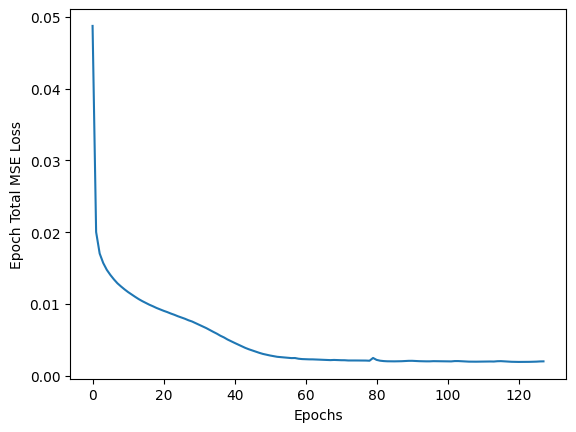

In [53]:
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Epoch Total MSE Loss")
plt.show()

In [54]:
test_loss=0
for inputs,labels in tqdm(test_loader, "Testing model on test data and computing MSE loss"):
    inputs = (inputs.unsqueeze(1)/255.0).to(device)
    labels = (labels.permute(0,3,1,2)/255.0).to(device)
    outputs = cnn(inputs)
    loss= criterion(outputs,labels)
    test_loss+=loss.item()
#     print(inputs[0])
#     print(labels[0])
#     print(outputs[0])
#     print(test_loss)
#     break
test_loss/=len(test_loader)
print(f"\nTest MSE loss = {test_loss:.4f}")

Testing model on test data and computing MSE loss: 100%|██████████| 23/23 [00:00<00:00, 44.11it/s]


Test MSE loss = 0.0057


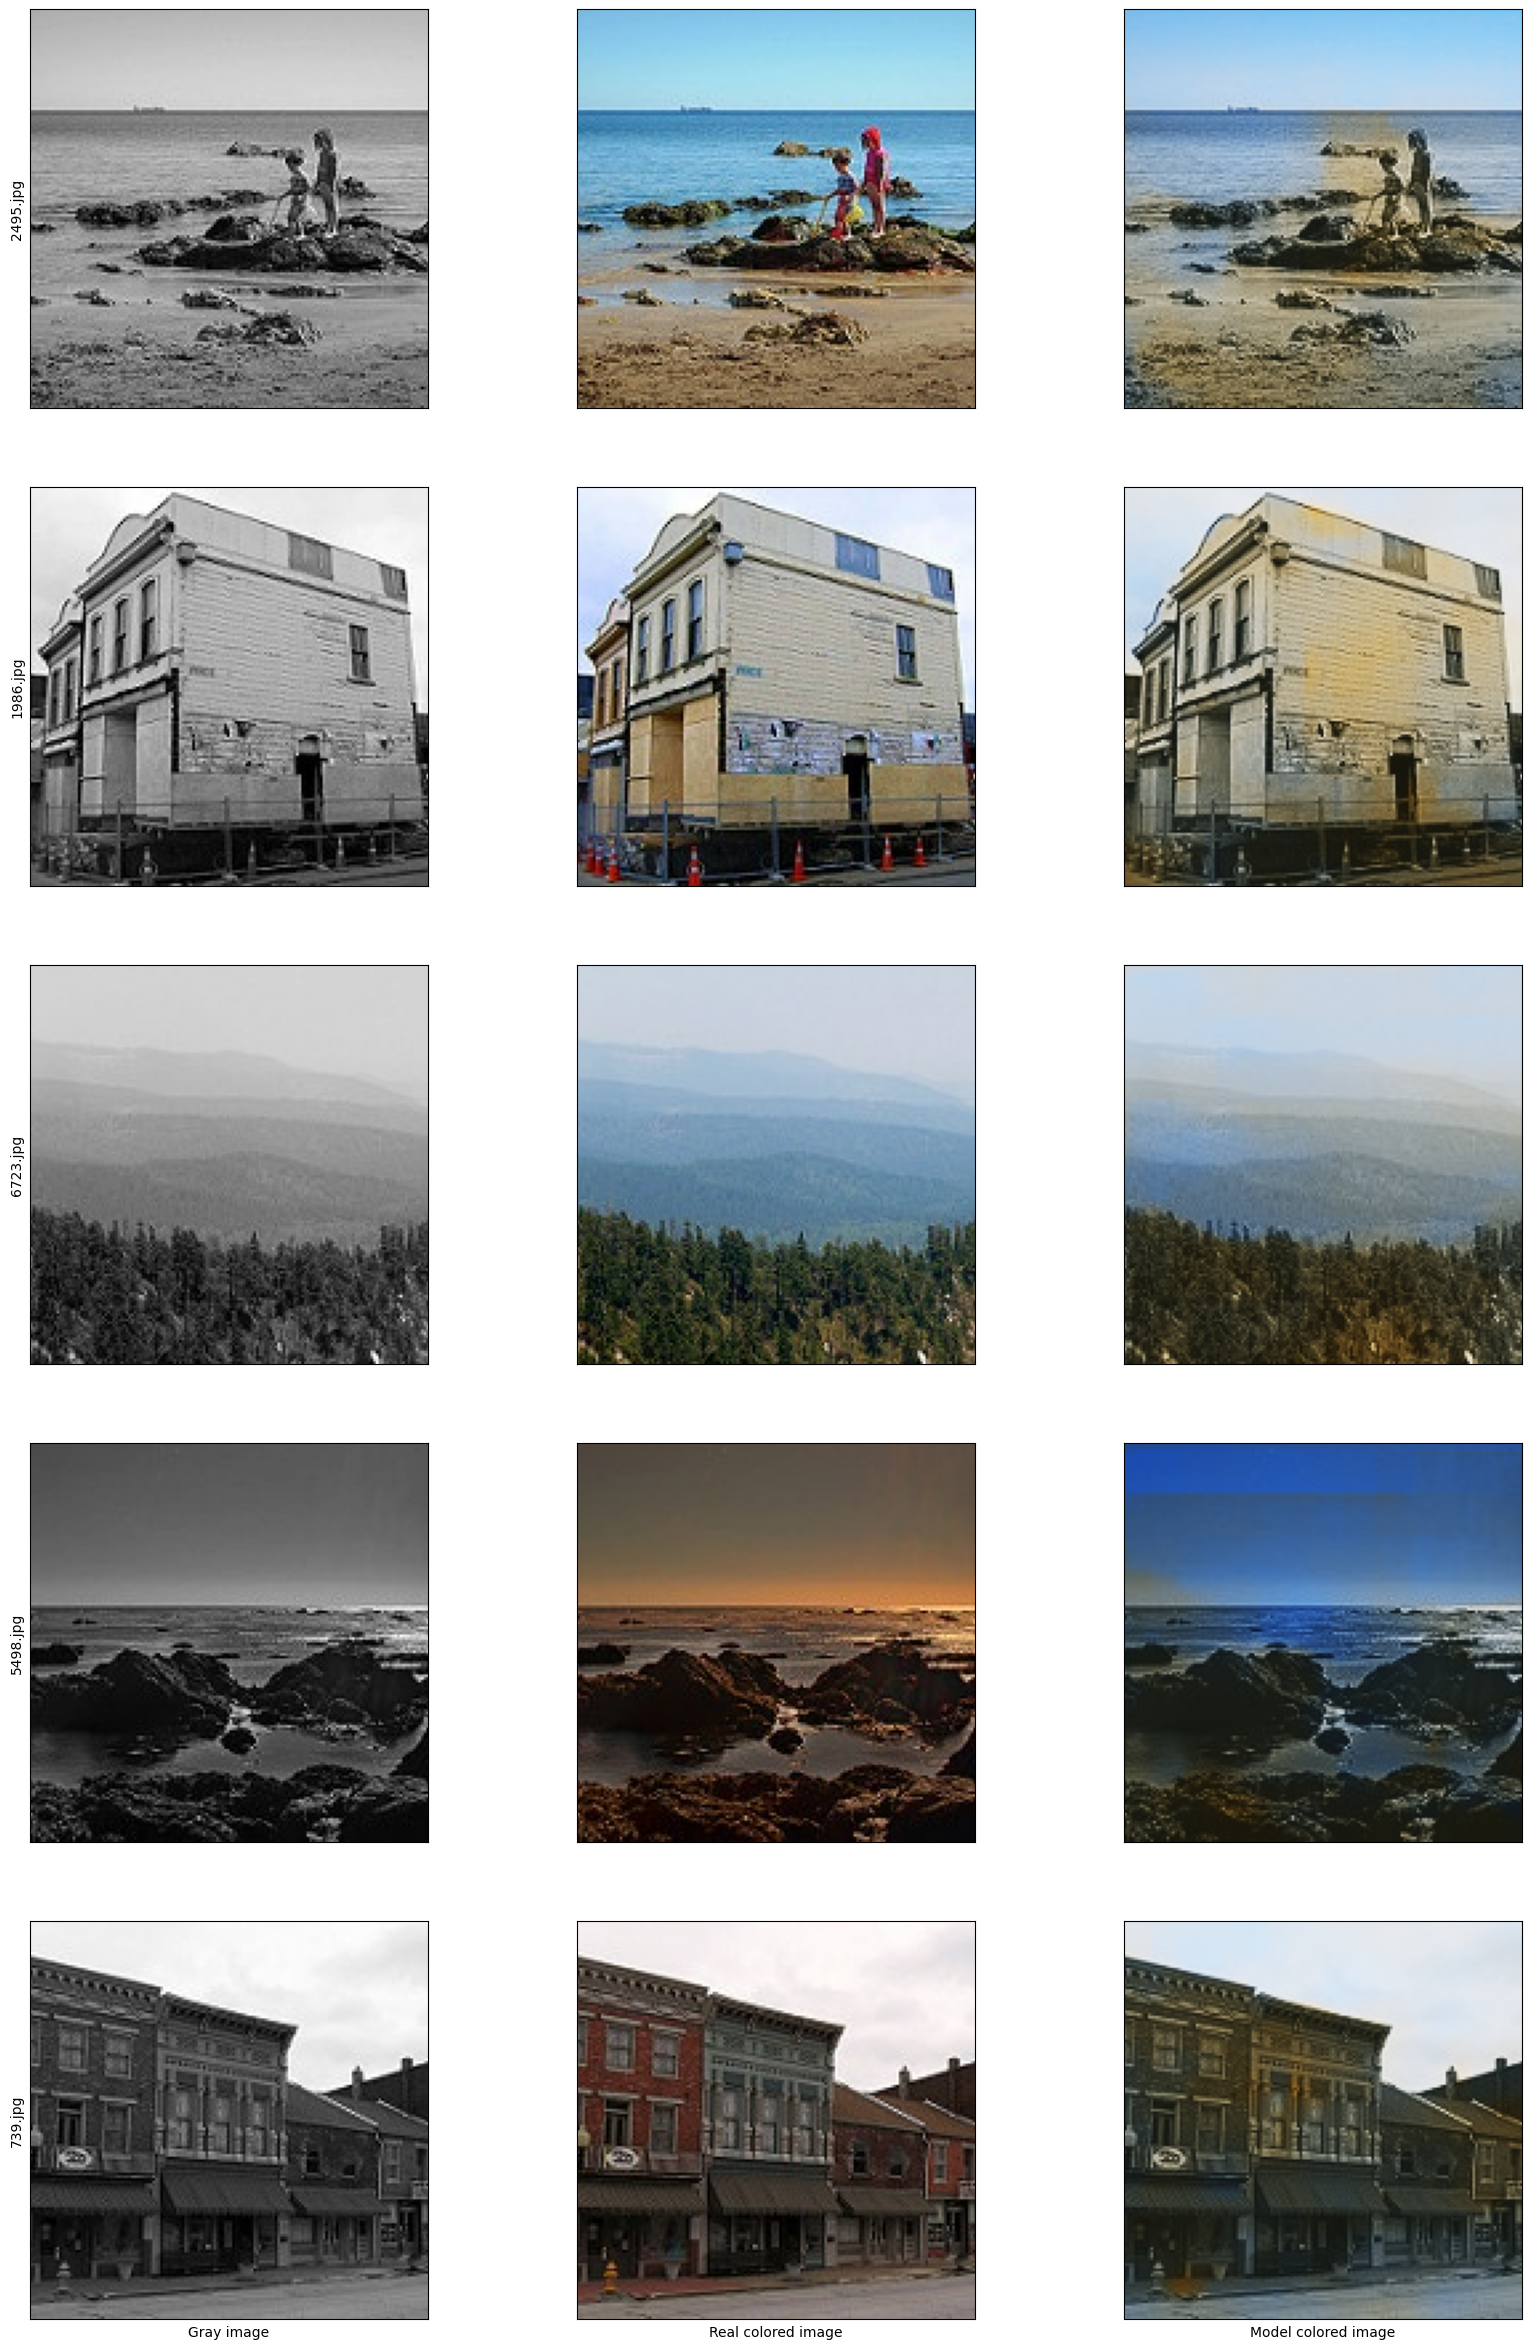

In [61]:
n_samples = 5
fig,axes = plt.subplots(n_samples,3,figsize=(20,30),sharex=True)
for i in range(n_samples):
    picture = test_data[np.random.choice(np.arange(0,len(test_data)))]
    axes[i,0].imshow(picture[1],cmap='gray')
    axes[i,1].imshow(picture[2])
#     print(picture[1])
    image = (torch.tensor(picture[1]).to(device).unsqueeze(0).unsqueeze(0))/255.0
    # print(image.shape)
#     print("***************")
    colored_image = cnn(image).squeeze(0).permute(1,2,0).cpu().detach().numpy()
#     print(colored_image*255)
    # print(colored_image.shape)
    # print(colored_image*255)
#     print(picture[2])
#     print("&&&&&&&&&&&&&&&")
    axes[i,2].imshow(colored_image)
    axes[i,0].set_xticks([])
    axes[i,1].set_xticks([])
    axes[i,2].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,1].set_yticks([])
    axes[i,2].set_yticks([])
    axes[i,0].set_ylabel(picture[0])
#     break
axes[i,0].set_xlabel("Gray image")
axes[i,1].set_xlabel("Real colored image")
axes[i,2].set_xlabel("Model colored image")
plt.show()

In [63]:
import h5py

# Assuming 'model' is your trained PyTorch model
# Assuming 'path' is the path where you want to save the model in H5 format

# Create an HDF5 file
with h5py.File('trained_model.h5', 'w') as f:
    # Iterate through all parameters in the model
    for name, param in cnn.named_parameters():
        # Convert the PyTorch tensor to numpy array
        param_value = param.cpu().detach().numpy()
        # Create a dataset in the HDF5 file with the parameter name and store the parameter value
        f.create_dataset(name, data=param_value)

In [65]:
with h5py.File('trained_model.h5', 'r') as f:
    # Create an instance of your PyTorch model
    model = ImageColorizerCNNAutoEncoder()
    # Iterate through all parameters in the HDF5 file
    for name in f.keys():
        print(name)
        # Load the parameter value from the HDF5 file
        param_value = f[name][()]
        # Assign the parameter value to the corresponding parameter in the model
#         getattr(model, name).data = torch.tensor(param_value)
print(model)

cat.0.bias
cat.0.weight
decoder.0.bias
decoder.0.weight
decoder.10.bias
decoder.10.weight
decoder.12.bias
decoder.12.weight
decoder.14.bias
decoder.14.weight
decoder.2.bias
decoder.2.weight
decoder.4.bias
decoder.4.weight
decoder.6.bias
decoder.6.weight
decoder.8.bias
decoder.8.weight
encoder.0.bias
encoder.0.weight
encoder.3.bias
encoder.3.weight
encoder.6.bias
encoder.6.weight
encoder.9.bias
encoder.9.weight
ImageColorizerCNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Max